# Directories

In [79]:
import os
mode = -1
try:
    os.getlogin() # This will return an exception if ran in Google colab
    mode = 'local'
except:
    # Install necessary files and create necessary folders (Only when ran in Google Drive)
    !pip install snntorch
    !pip install torch
    !pip install gym
    !pip install gym[box2d]
    !mkdir tmp
    !mkdir logs
    #from google.colab import drive
    #drive.mount('/content/drive')
    #!cp "/content/drive/MyDrive/Colab Notebooks/dict9 LIF" "/content/tmp/"
    mode = 'colab'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘tmp’: File exists
mkdir: cannot create directory ‘logs’: File exists


# Imports

In [80]:
import gym
import time
import numpy as np
import pandas as pd
import pickle
import random
from datetime import datetime
from collections import deque, namedtuple
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import snntorch as snn
from snntorch import spikegen
from snntorch import surrogate

import warnings
warnings.filterwarnings('ignore')

In [81]:
# A small method to save plots
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=resolution)

# Parameters ###

In [82]:
env_name = 'BipedalWalker-v3'
env_name_clean = env_name.lower().replace('-','_')
filename = env_name_clean + ".png"
outfilename = env_name_clean + "scoreboard.txt"
datename = str(datetime.now()).split('.')[0].replace(' ', '_').replace('-', '_').replace(':', '_') 
scorefigname = env_name_clean + '_' + datename + '_scores.png'
epsfigname = env_name_clean + '_' + datename + '_eps_history.png'
cumfigname = env_name_clean + '_' + datename + '_cumulated_reward.png'
distfigname = env_name_clean + '_' + datename + '_distances.png'
meandistfigname = env_name_clean + '_' + datename + '_mean_distances.png'
model_file = './tmp/'  + env_name_clean + '_dict9'
model_file_target = model_file + '_target'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Env name (clean):',env_name_clean)
print('Datetime (clean):', datename)
print('Output file:', outfilename)
print('Model file:', model_file)
print('Running training on: ', device)
print('Environment:', mode)

Env name (clean): bipedalwalker_v3
Datetime (clean): 2022_11_18_16_31_17
Output file: bipedalwalker_v3scoreboard.txt
Model file: ./tmp/bipedalwalker_v3_dict9
Running training on:  cuda
Environment: colab


In [83]:
lr = 0.0005             # Learning rate
epsilon = 0.2
epsilon_end = 0.01
epsilon_decay = 0.994
gamma = 0.99
batch_size = 64
mean_every = 2
update_every = 4
tau = 1e-3
gauss_per_dim = 64
n_games = 1000          # Number of games to train for
n_rounds = 5            # Number of competitive rounds to play

# Classes

## Net

In [84]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, beta=0.95):
        super(Net, self).__init__()

        # Initialize grad objects        
        spike_grad1 = surrogate.fast_sigmoid()
        spike_grad2 = surrogate.fast_sigmoid()
        spike_grad3 = surrogate.fast_sigmoid()
        # spike_grad4 = surrogate.fast_sigmoid() # Uncomment for 4 layers

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, 512)
        self.lif1 = snn.Leaky(beta=beta, learn_threshold=False, spike_grad=spike_grad1)
        
        self.fc2 = nn.Linear(512, 128)
        self.lif2 = snn.Leaky(beta=beta, learn_threshold=False, spike_grad=spike_grad2)

        self.fc3 = nn.Linear(128, num_outputs) # COMMENT for 4 layers
        self.lif3 = snn.Leaky(beta=beta, learn_beta=True, threshold=1e5, reset_mechanism="none", spike_grad=spike_grad3)

        # self.fc3 = nn.Linear(256, 128) # Uncomment for 4 layers
        # self.lif3 = snn.Leaky(beta=beta, learn_threshold=False, spike_grad=spike_grad3)

        # self.fc4 = nn.Linear(128, num_outputs) # Uncomment for 4 layers
        # self.lif4 = snn.Leaky(beta=beta, learn_beta=True, threshold=1e5, reset_mechanism="none", spike_grad=spike_grad4) # Uncomment for 4 layers

    def _convert_to_spikes(self, data):
        return snn.spikegen.delta(data, threshold=0.1, padding=False, off_spike=True)

    def createGauss(self, mins, maxes, numPerDim, amplMax, dims):
        self.amplMax = amplMax
        self.numPerDim = numPerDim
        self.M = []
        self.sigma = []
        for i in range(dims):
            M, sigma = np.linspace(mins[i], maxes[i], numPerDim, retstep=True)
            self.M.append(M)
            self.sigma += [sigma, ] * self.numPerDim
        self.M = torch.tensor(np.array(self.M).reshape(-1, self.numPerDim), dtype=torch.float).to(device)
        self.sigma = torch.tensor(np.array(self.sigma).reshape(-1, self.numPerDim), dtype=torch.float).to(device)

    def gaussianCurrents(self, data):
        x = data.unsqueeze(-1).repeat([1, 1, self.numPerDim])
        return (torch.exp(-1 / 2 * ((x - self.M) / self.sigma) ** 2) * self.amplMax).reshape(data.shape[0], -1)

    def forward(self, x, num_steps=16):
        x = self.gaussianCurrents(x)
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        # mem4 = self.lif3.init_leaky() # Uncomment for 4 layers

        # Record the final layer#
        spk1_rec = []
        mem1_rec = []
        
        spk2_rec = []
        mem2_rec = []
        
        spk3_rec = []
        mem3_rec = []        
        
        # spk4_rec = [] # Uncomment for 4 layers
        # mem4_rec = []  

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            
            # cur4 = self.fc4(spk3) # Uncomment for 4 layers
            # spk4, mem4 = self.lif4(cur4, mem4)
            
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)
            
            # spk4_rec.append(spk4) # Uncomment for 4 layers
            # mem4_rec.append(mem4)

        return x, [torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(spk3_rec, dim=0),
                torch.stack(mem1_rec, dim=0), torch.stack(mem2_rec, dim=0), torch.stack(mem3_rec, dim=0)], \
               torch.stack(mem3_rec, dim=0)

## ReplayBuffer

In [85]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed=42):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

## Agent

In [86]:
class Agent():
    def __init__(self, state_size, action_size, seed, buffer_size, batch_size, gamma, tau, learning_rate, update_every, low, high, gaussPerDim, model_file):
        self.batch_size = batch_size
        self.gamma = gamma
        self.state_size = state_size
        self.n_actions = 3 ** action_size
        self.tau = tau
        self.update_every = update_every
        self.seed = random.seed(seed)
        self.model_file = model_file
        self.low = low
        self.high = high
        self.dtype = torch.float
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.mem_size = 1000000
        self.gaussPerDim = gaussPerDim
        gaussPerDim = 64

        # Q-Network
        ## Local
        self.qnetwork_local = Net(state_size * gaussPerDim, action_size, seed).to(device)
        self.qnetwork_local.createGauss(self.low, self.high, gaussPerDim, 1.0, state_size)
        ## Target
        self.qnetwork_target = Net(state_size * gaussPerDim, action_size, seed).to(device)
        self.qnetwork_target.createGauss(self.low, self.high, gaussPerDim, 1.0, state_size)
        
        self.optimizer = torch.optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate, betas=(0.9, 0.999))

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def get_action(self, action_idx):
        action = []
        
        # Joint 1
        output = int(action_idx / 27) - 1
        rest = action_idx - 27 * int(action_idx / 27)
        action.append(output)
        
        # Joint 2
        output = int(rest / 9) - 1
        rest = rest - 9 * int(rest / 9)
        action.append(output)
        
        # Joint 3
        output = int(rest / 3) - 1
        rest = rest - 3 * int(rest / 3)
        action.append(output)
        
        # Joint 4
        action.append(rest - 1)

        return action

    def act(self, state, eps): # Choose action based on state
        state = state[np.newaxis, :]
        with torch.no_grad():
            self.qnetwork_local.eval()
            gaussX, spikes, actions = self.qnetwork_local(torch.tensor(state, dtype=self.dtype).to(self.device))
            actions = actions.cpu()[-1, 0, :].detach().numpy()
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            action_idx = action = np.argmax(actions)
        else:
            action_idx = int(random.randrange(self.n_actions))
        return self.get_action(action_idx)

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                return self.learn(experiences, self.gamma)
        return None

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        gaussX, spikes, Q_targets_next = self.qnetwork_target(next_states)
        
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        gaussX, spikes, Q_expected = self.qnetwork_local(states)#.gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)
        return loss.cpu().data.numpy()

    def soft_update(self, local_model, target_model, tau):
        # Update the target model parameters based on tau (soft update learning rate)
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def save_models(self):
        torch.save(self.qnetwork_local.state_dict(), self.model_file)
    
    def load_models(self):
        self.qnetwork_local.load_state_dict(torch.load(self.model_file, map_location=torch.device('cpu')))
        self.qnetwork_local.eval()

# Setup

In [87]:
stime = time.time()
env = gym.make(env_name, render_mode='rgb_array')

n_actions = -1
gymtype = -1
if(type(env.action_space) == gym.spaces.box.Box):    
    n_actions = int(env.action_space.shape[0])
    gymtype = 'box'
else:
    n_actions = int(env.action_space.n)
    gymtype = 'disc'

n_input_dims = int(env.observation_space.shape[0]) # If the state space is not an 1-D vector then we need to change this

agent = Agent(state_size=n_input_dims, action_size=n_actions, seed=420, buffer_size=int(1e5), batch_size=batch_size, gamma=gamma, 
              tau=tau, learning_rate=lr, update_every=update_every, low=env.observation_space.low, high=env.observation_space.high, 
              gaussPerDim = gauss_per_dim, model_file=model_file)

scores = [] # Logged every episode
eps_history = [] # Logged every episode
avg_scores = [] # Logged every 10 episodes

if(os.path.exists(model_file)):
    try: 
        agent.load_models()
    except:
        !rm -rf model_file
        agent.save_models()
else:
    agent.save_models()

state = agent.qnetwork_local.state_dict()
state["lif1.beta"] = torch.tensor(0.95,dtype=torch.float).to(device)
state["lif2.beta"] = torch.tensor(0.95, dtype=torch.float).to(device)
state["lif3.beta"] = torch.tensor(1.0, dtype=torch.float).to(device)
# state["lif4.beta"] = torch.tensor(1.0, dtype=torch.float).to(device) # Uncomment for 4 layers
agent.qnetwork_local.load_state_dict(state)

print('gymtype:', gymtype)
print('lif1 beta:', agent.qnetwork_local.lif1.beta)
print('lif2 beta:', agent.qnetwork_local.lif2.beta)
print('lif3 beta:', agent.qnetwork_local.lif3.beta)
print('Action space:', env.action_space)
print('Observation space:', env.observation_space)
#print('High:', env.observation_space.high)
#print('Low:', env.observation_space.low)

gymtype: box
lif1 beta: tensor(0.9500, device='cuda:0')
lif2 beta: tensor(0.9500, device='cuda:0')
lif3 beta: Parameter containing:
tensor(1., device='cuda:0', requires_grad=True)
Action space: Box(-1.0, 1.0, (4,), float32)
Observation space: Box([-3.1415927 -5.        -5.        -5.        -3.1415927 -5.
 -3.1415927 -5.        -0.        -3.1415927 -5.        -3.1415927
 -5.        -0.        -1.        -1.        -1.        -1.
 -1.        -1.        -1.        -1.        -1.        -1.       ], [3.1415927 5.        5.        5.        3.1415927 5.        3.1415927
 5.        5.        3.1415927 5.        3.1415927 5.        5.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.       ], (24,), float32)


# Train

In [89]:
scores = []
mean_scores = []
last_scores = deque(maxlen=mean_every)
distances = []
mean_distances = []
last_distance = deque(maxlen=mean_every)
losses_mean_episode = []
eps_history = []

ep = -1
while ep < n_games:
    ep += 1
    done = False
    state = env.reset()
    total_reward = 0
    total_distance = 0
    losses = []
    
    while(not done):
        action = agent.act(state, epsilon)
        
        next_state, reward, done, info = env.step(action)
        
        loss = agent.step(state, action, reward, next_state, done)
        
        state = next_state
        
        total_reward += reward

        if(loss is not None):
            losses.append(loss)

        if(reward != -100):
            total_distance += reward
    
    epsilon = max(epsilon_end, epsilon_decay * epsilon)

    if len(losses) >= 1:
        mean_loss = np.mean(losses)
        losses_mean_episode.append((ep, mean_loss))
    else:
        mean_loss = None

    # print('episode:',ep,'/',n_games,'\t score:',total_reward,'\t distance:',total_distance,'\t loss:',mean_loss,'\t epsilon:',epsilon)

    scores.append(total_reward)
    distances.append(total_distance)
    last_scores.append(total_reward)
    last_distance.append(total_distance)
    mean_score = np.mean(last_scores)
    mean_distance = np.mean(last_distance)
    eps_history.append(epsilon)

    # record rewards dynamically
    FILE = 'record.dat'
    data = [ep, total_reward, total_distance, mean_loss, epsilon]
    with open(FILE, "ab") as f:
        pickle.dump(data, f)

    if (mean_score >= 300):
        print('environment solved in:',ep,'\t mean score:',mean_score)
        torch.save(agent.qnetwork_local.state_dict(), model_file)
        torch.save(agent.qnetwork_target.state_dict(), model_file_target)
        break

    # save model every MEAN_EVERY episodes
    if ((ep % mean_every) == 0):        
        print('episode:',ep,'/',n_games,'\t mean score:',mean_score,'\t mean distance:',mean_distance,'\t mean loss:',mean_loss,'\t epsilon:',epsilon)

        torch.save(agent.qnetwork_local.state_dict(), model_file)
        torch.save(agent.qnetwork_target.state_dict(), model_file_target)
        
        mean_scores.append(mean_score)
        mean_distances.append(mean_distance)
        
        FILE = 'record_mean.dat'
        data = [ep, mean_score, mean_distance, mean_loss, epsilon]
        with open(FILE, "ab") as f:
            pickle.dump(data, f)
env.close()

episode: 0 / 1000 	 mean score: -117.3690604927111 	 mean distance: -17.369060492711103 	 mean loss: 98.55355 	 epsilon: 0.1905991988571696
episode: 2 / 1000 	 mean score: -93.72040025583891 	 mean distance: -43.72040025583892 	 mean loss: 31.544144 	 epsilon: 0.18831887004204242
episode: 4 / 1000 	 mean score: -107.64822228168882 	 mean distance: -7.648222281688822 	 mean loss: 16.548191 	 epsilon: 0.18606582308085945
episode: 6 / 1000 	 mean score: -150.84677635453298 	 mean distance: -50.84677635453296 	 mean loss: 6.798706 	 epsilon: 0.18383973157352004
episode: 8 / 1000 	 mean score: -116.91279484823683 	 mean distance: -16.912794848236828 	 mean loss: 30.249714 	 epsilon: 0.18164027302497446
episode: 10 / 1000 	 mean score: -111.58844996409675 	 mean distance: -11.588449964096753 	 mean loss: 13.505496 	 epsilon: 0.17946712879850366
episode: 12 / 1000 	 mean score: -110.94796343371488 	 mean distance: -10.947963433714877 	 mean loss: 21.50498 	 epsilon: 0.17731998406955837
episod

# Plot

Total time:  7315.537520647049
Saving figure bipedalwalker_v3_2022_11_18_16_31_17_scores.png


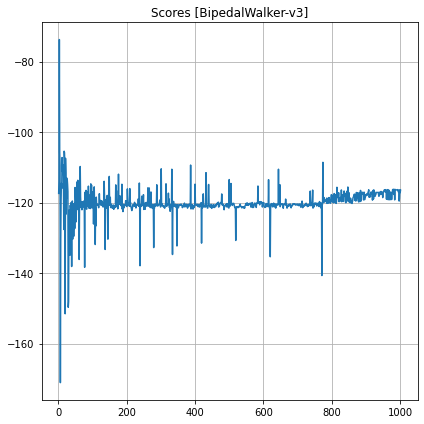

In [90]:
print("Total time: ", time.time() - stime)

x = [idx + 1 for idx in range(len(scores))]

plt.figure(figsize=(6,6))
plt.plot(x, scores)
plt.title('Scores [' + env_name + ']')
plt.grid()
save_fig(scorefigname)
plt.show()

Saving figure bipedalwalker_v3_2022_11_18_16_31_17_cumulated_reward.png


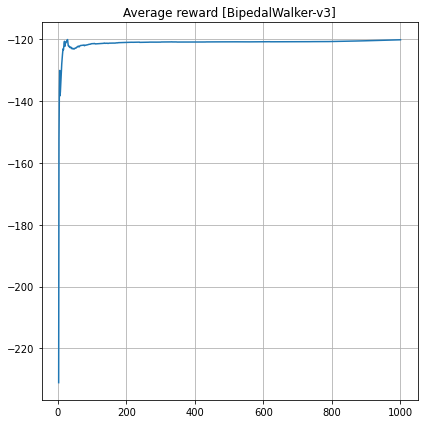

In [91]:
c_reward = np.cumsum(scores)
c_indices = np.arange(len(c_reward))
rolling_avg = c_reward / c_indices

plt.figure(figsize=(6,6))
plt.plot(x, rolling_avg)
plt.title('Average reward [' + env_name + ']')
plt.grid()
save_fig(cumfigname)
plt.show()

Saving figure bipedalwalker_v3_2022_11_18_16_31_17_eps_history.png


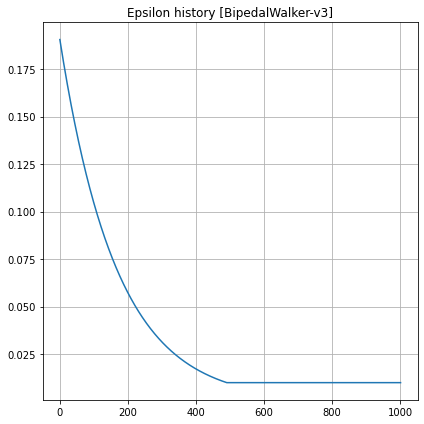

In [92]:
plt.figure(figsize=(6,6))
plt.plot(x, eps_history)
plt.title('Epsilon history [' + env_name + ']')
plt.grid()
save_fig(epsfigname)
plt.show()

Saving figure bipedalwalker_v3_2022_11_18_16_31_17_distances.png


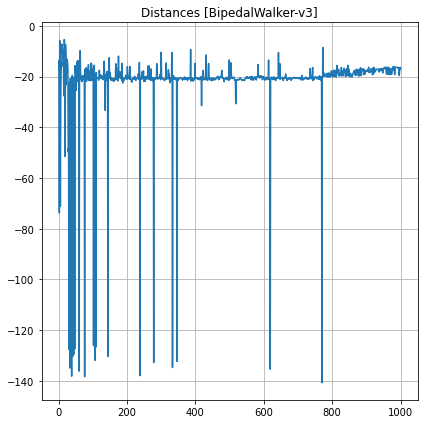

In [93]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(len(distances)), distances)
plt.title('Distances [' + env_name + ']')
plt.grid()
save_fig(distfigname)
plt.show()

Saving figure bipedalwalker_v3_2022_11_18_16_31_17_mean_distances.png


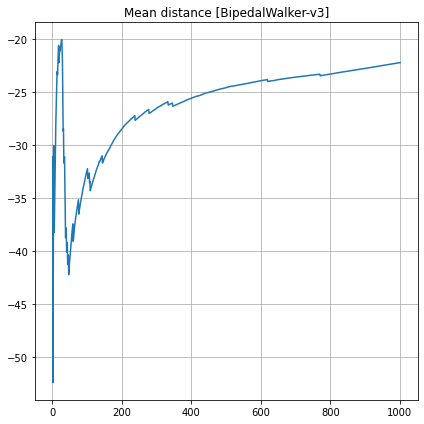

In [94]:
c_distances = np.cumsum(distances)
c_indices_distances = np.arange(len(c_distances))
rolling_avg_distances = c_distances / c_indices_distances

plt.figure(figsize=(6,6))
plt.plot(x, rolling_avg_distances)
plt.title('Mean distance [' + env_name + ']')
plt.grid()
save_fig(meandistfigname)
plt.show()

# Log

In [95]:
dfname = datename + '_runlogs'
df_path = 'logs/' + env_name_clean + '_' + dfname + '.csv'
df_avg_path = 'logs/' + env_name_clean + '_' + dfname + '_avg.csv'
df_dist_path = 'logs/' + env_name_clean + '_' + dfname + '_distances.csv'

df = pd.DataFrame({'score': scores, 'Epsilon': eps_history})
df_avg = pd.DataFrame({'avg_score': avg_scores})
df_dist = pd.DataFrame({'distances': distances})

df.to_csv(df_path, sep = ';', header = True, index = False)
df_avg.to_csv(df_avg_path, sep = ';', header = True, index = False)
df_dist.to_csv(df_dist_path, sep = ';', header = True, index = False)

print("Done logging results")

Done logging results


# Eval

In [97]:
print('Starting competitive trials...')
compscores = 0
agent.load_models()
print('epsilon', epsilon)

Starting competitive trials...
epsilon 0.01


In [99]:
for i in range(n_rounds):
    done = False
    state = env.reset()
    score = 0

    while not done:
        env.render()
        
        action = agent.act(state, epsilon)
        
        next_state, reward, done, info = env.step(action)

        agent.memory.add(state, action, reward, next_state, done)
        
        state = next_state
        score += reward
    
    compscores += score
    print("Competitive round ", i + 1, " Overall score ", compscores)

Competitive round  1  Overall score  -116.40246865483063
Competitive round  2  Overall score  -232.80383083076651
Competitive round  3  Overall score  -348.3497732047662
Competitive round  4  Overall score  -464.7019889113512
Competitive round  5  Overall score  -581.1347620029866


# Score

In [100]:
with open(outfilename, "w") as f:
    f.writelines("%s: %i\n" % (env_name_clean, compscores))

In [101]:
if(mode == 'colab'):
    from google.colab import files
    files.download(model_file)
    files.download(outfilename)
    files.download(df_path)
    files.download(df_avg_path)
    files.download(df_dist_path)
    files.download('images/' + scorefigname)
    files.download('images/' + epsfigname)
    files.download('images/' + cumfigname)
    files.download('images/' + distfigname)
    files.download('images/' + meandistfigname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>